In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                  
from random import randint               
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential  
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['angry', 'shock', 'normal', 'smile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
IMAGE_SIZE = (120, 120)

In [3]:
def load_data():
    """
        Load the data:
            - 400 images to train the network.
            - 80 images to evaluate how accurately the network learned to classify images.
    """
    filters = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    datasets = ['dataset_iron_1m/train', 'dataset_iron_1m/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                image = cv2.filter2D(image,-1,filters)
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

 25%|████████████████████                                                            | 25/100 [00:00<00:00, 243.37it/s]

Loading dataset_iron_1m/train


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Loading dataset_iron_1m/test


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 270.99it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
# Exploring Datasets

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of Class: {}".format(nb_classes))
print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of Class: 4
Number of training examples: 400
Number of testing examples: 80
Each image is of size: (120, 120)


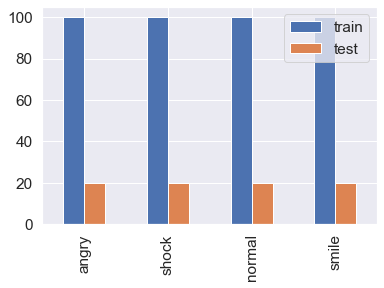

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

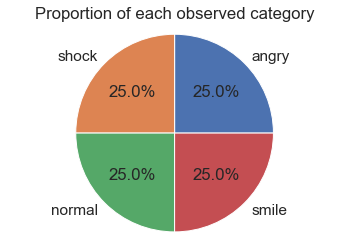

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%'
        )
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
# Data Normalization

train_images = train_images / 255.0 
test_images = test_images / 255.0

In [10]:
# Visualize the Data

def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

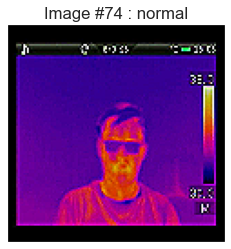

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

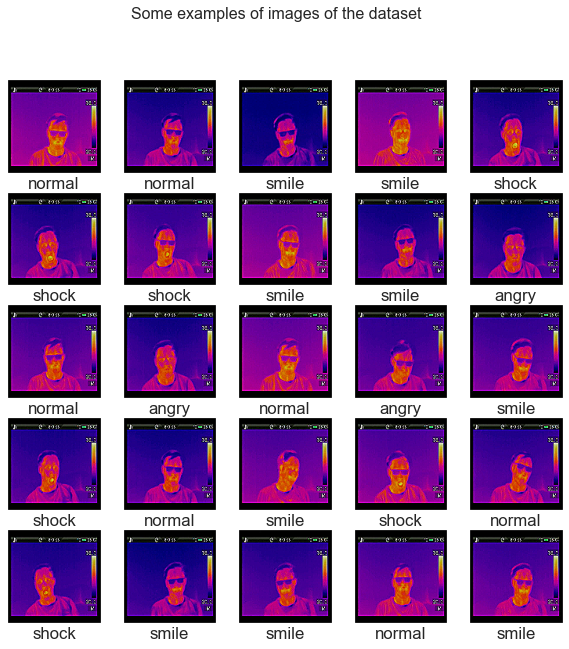

In [13]:
display_examples(class_names, train_images, train_labels)

In [14]:
# CNN models

model = Models.Sequential()

# CNN Architecture

model.add(Layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(120, 120, 3)))
model.add(Layers.MaxPool2D(2,2))
model.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(2,2))
model.add(Layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(2,2))
model.add(Layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(2,2))

# ANN Architecture

model.add(Layers.Flatten())

model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(1000, activation='relu'))

model.add(Layers.Dense(4, activation='softmax'))

# Compiling Model

model.compile(optimizer=Optimizer.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 256)       2

In [16]:
import time

# START OF TIME
start = time.time()

### MODEL FITTING
history = model.fit(train_images, 
                    train_labels, 
                    batch_size= 16, 
                    epochs= 120,
                    validation_split=0.2
                    )
### MODEL FITTING

# END OF TIME
end = time.time()

# RESULT
print("Time elapsed for this training section: {0:.2f}s".format(end - start))

# EPOCHS RUNTIME

# 30 Epochs = 75.61s
# 60 Epochs = 147.82s
# 90 Epochs = 220.07
# 120 Epochs = 292.83

Epoch 1/120
20/20 [==============================] - 7s 226ms/step - loss: 1.3865 - accuracy: 0.2731 - val_loss: 1.3862 - val_accuracy: 0.3000
Epoch 2/120
20/20 [==============================] - 2s 120ms/step - loss: 1.3748 - accuracy: 0.3074 - val_loss: 1.3708 - val_accuracy: 0.4750
Epoch 3/120
20/20 [==============================] - 2s 120ms/step - loss: 1.3720 - accuracy: 0.3959 - val_loss: 1.3607 - val_accuracy: 0.5000
Epoch 4/120
20/20 [==============================] - 2s 120ms/step - loss: 1.3566 - accuracy: 0.5114 - val_loss: 1.3510 - val_accuracy: 0.4875
Epoch 5/120
20/20 [==============================] - 2s 121ms/step - loss: 1.3494 - accuracy: 0.5542 - val_loss: 1.3364 - val_accuracy: 0.5250
Epoch 6/120
20/20 [==============================] - 2s 120ms/step - loss: 1.3341 - accuracy: 0.5953 - val_loss: 1.3181 - val_accuracy: 0.6000
Epoch 7/120
20/20 [==============================] - 2s 120ms/step - loss: 1.3105 - accuracy: 0.6620 - val_loss: 1.2963 - val_accuracy: 0.5875

Epoch 58/120
20/20 [==============================] - 2s 120ms/step - loss: 0.2542 - accuracy: 0.9132 - val_loss: 0.1816 - val_accuracy: 1.0000
Epoch 59/120
20/20 [==============================] - 2s 121ms/step - loss: 0.2370 - accuracy: 0.9280 - val_loss: 0.1853 - val_accuracy: 0.9875
Epoch 60/120
20/20 [==============================] - 2s 120ms/step - loss: 0.1991 - accuracy: 0.9520 - val_loss: 0.1833 - val_accuracy: 0.9875
Epoch 61/120
20/20 [==============================] - 2s 121ms/step - loss: 0.2235 - accuracy: 0.9387 - val_loss: 0.1660 - val_accuracy: 1.0000
Epoch 62/120
20/20 [==============================] - 2s 120ms/step - loss: 0.1750 - accuracy: 0.9609 - val_loss: 0.1688 - val_accuracy: 0.9875
Epoch 63/120
20/20 [==============================] - 2s 121ms/step - loss: 0.2028 - accuracy: 0.9497 - val_loss: 0.1651 - val_accuracy: 1.0000
Epoch 64/120
20/20 [==============================] - 2s 120ms/step - loss: 0.2266 - accuracy: 0.9308 - val_loss: 0.1485 - val_accuracy:

Epoch 115/120
20/20 [==============================] - 2s 121ms/step - loss: 0.0528 - accuracy: 0.9995 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 116/120
20/20 [==============================] - 2s 120ms/step - loss: 0.0611 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 117/120
20/20 [==============================] - 2s 121ms/step - loss: 0.0607 - accuracy: 0.9924 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 118/120
20/20 [==============================] - 2s 120ms/step - loss: 0.0458 - accuracy: 0.9947 - val_loss: 0.0310 - val_accuracy: 1.0000
Epoch 119/120
20/20 [==============================] - 2s 121ms/step - loss: 0.0433 - accuracy: 0.9972 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 120/120
20/20 [==============================] - 2s 120ms/step - loss: 0.0446 - accuracy: 0.9920 - val_loss: 0.0258 - val_accuracy: 1.0000
Time elapsed for this training section: 292.83s


In [17]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

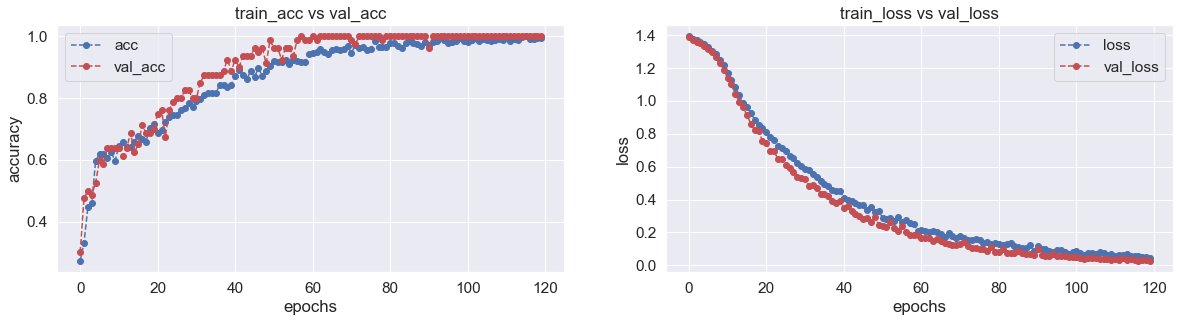

In [18]:
plot_accuracy_loss(history)

In [19]:
loss, acc = model.evaluate(test_images, test_labels)

print("System Accuracy : {0:.2f}%".format(acc*100))
print("System Loss : {0:.5f}".format(loss))

# 30 Epochs, Accuracy = 83.75%
# 60 Epochs, Accuracy = 95.00%
# 90 Epochs, Accuracy = 97.50
# 120 Epochs Accuracy = 100%

3/3 [==============================] - 1s 45ms/step - loss: 0.0366 - accuracy: 1.0000
System Accuracy : 100.00%
System Loss : 0.03664


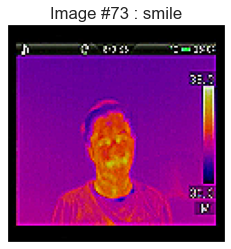

In [20]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [21]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

IndexError: index 0 is out of bounds for axis 0 with size 0

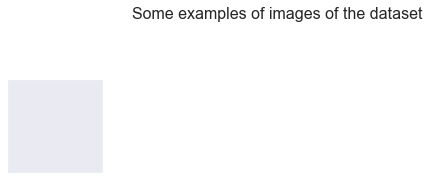

In [22]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

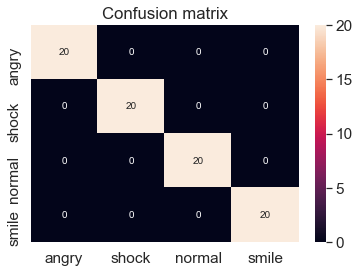

In [23]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()